# OGC-TDML (pytdml) to GeoCroissant Conversion
<img src="../../assets/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">

This notebook demonstrates how to convert a dataset from the OGC-TDML format (using `pytdml`) to the GeoCroissant JSON-LD format, validate the output, and use the resulting metadata for machine learning workflows.

## Field Mapping: OGC-TDML vs GeoCroissant

| OGC-TDML Field      | GeoCroissant Field      | Notes/Mapping Logic                                      |
|---------------------|------------------------|----------------------------------------------------------|
| `id`                | `identifier`           | Direct mapping                                           |
| `name`              | `name`                 | Sanitized for forbidden characters                       |
| `description`       | `description`          | Direct mapping                                           |
| `license`           | `license`              | Direct mapping                                           |
| `providers`         | `creator`              | Direct mapping                                           |
| `created_time`      | `dateCreated`          | Direct mapping                                           |
| `updated_time`      | `dateModified`         | Direct mapping                                           |
| `created_time`      | `datePublished`        | Used for both created and published date                 |
| `version`           | `version`              | Direct mapping                                           |
| `classes`           | `variableMeasured`     | Each class as `{name, description}`                      |
| `bands`             | `variableMeasured`     | Each band as `{name, unitText}`                          |
| `data`              | `distribution`         | Each image/mask as a distribution entry                  |
| `extent`            | `spatialCoverage`      | Converted to GeoJSON Polygon                             |
| `tasks`             | *(not mapped)*         | Not included in standard GeoCroissant                    |
| ...                 | ...                    | ...                                                      |

In [1]:
import json
import re
import pytdml.io


def safe_str(value, default="Unknown"):
    """Return string if value is not None/empty, else default."""
    if value is None:
        return default
    return str(value)


def tdml_to_geocroissant(tdml_path, output_path):
    tdml = pytdml.io.read_from_json(tdml_path)

    # Build variableMeasured from classes and bands
    variable_measured = []
    if hasattr(tdml, "classes") and tdml.classes:
        variable_measured += [
            {
                "name": safe_str(getattr(c, "key", None)),
                "description": safe_str(
                    getattr(c, "value", None),
                    safe_str(getattr(c, "key", None), "Unknown class"),
                ),
            }
            for c in tdml.classes
            if c is not None
        ]
    if hasattr(tdml, "bands") and tdml.bands:
        # Handle bands structure from OGC-TDML
        for b in tdml.bands:
            if hasattr(b, "name") and b.name:
                first_name = b.name[0] if len(b.name) > 0 else "Unknown Band"
                band_name = safe_str(
                    getattr(first_name, "code", first_name), "Unknown Band"
                )
                band_info = {"name": band_name}
                units = getattr(b, "units", None)
                if units is not None:
                    band_info["unitText"] = safe_str(units)
                # Ensure description is always present
                band_info["description"] = safe_str(
                    getattr(b, "description", None), f"Band: {band_name}"
                )
                variable_measured.append(band_info)

    # Build distribution using proper FileObject/FileSet structure
    distribution = []

    # Create a FileObject for the main data directory
    distribution.append(
        {
            "@type": "cr:FileObject",
            "@id": "data_repo",
            "name": "data_repo",
            "description": "Directory containing the dataset files",
            "contentUrl": (
                "https://huggingface.co/datasets/harshinde/hls_burn_scars"
            ),  # Use actual URL from the data
            "encodingFormat": "local_directory",
            "md5": "placeholder_hash_for_directory",
        }
    )

    # Create single FileSet for all TIFF files
    distribution.append(
        {
            "@type": "cr:FileSet",
            "@id": "tiff-files-for-config-hls_burn_scars",
            "name": "tiff-files-for-config-hls_burn_scars",
            "description": "Local TIFF files organized in training/validation splits.",
            "containedIn": {"@id": "data_repo"},
            "encodingFormat": "image/tiff",
            "includes": "**/*.tif",
        }
    )

    # Build spatialCoverage - OGC-TDML doesn't have extent, so use description
    spatial_coverage = "Contiguous United States"  # From the description

    # Sanitize the name for forbidden characters
    sanitized_name = re.sub(
        r"[^A-Za-z0-9_-]", "_", safe_str(getattr(tdml, "name", "Unknown_Dataset"))
    )

    # Build recordSet with proper field structure and data
    record_data = []
    if hasattr(tdml, "data") and tdml.data:
        for i, d in enumerate(tdml.data):
            if d is None:
                continue
            record = {}
            if hasattr(d, "data_url") and d.data_url:
                first_url = d.data_url[0] if len(d.data_url) > 0 else None
                if first_url:
                    record[f"{sanitized_name}/image"] = safe_str(first_url)
            if hasattr(d, "labels") and d.labels:
                for label in d.labels:
                    if hasattr(label, "image_url") and label.image_url:
                        first_label_url = (
                            label.image_url[0] if len(label.image_url) > 0 else None
                        )
                        if first_label_url:
                            record[f"{sanitized_name}/mask"] = safe_str(first_label_url)
                            break
            if record:  # Only add if we have data
                record_data.append(record)

    record_set = {
        "@type": "cr:RecordSet",
        "@id": f"{sanitized_name}",
        "name": f"{sanitized_name}",
        "description": (
            f"HLS Burn Scars dataset with satellite imagery and burn scar mask"
            f" annotations."
        ),
        "field": [
            {
                "@type": "cr:Field",
                "@id": f"{sanitized_name}/image",
                "name": f"{sanitized_name}/image",
                "description": (
                    "Satellite imagery from Harmonized Landsat and Sentinel-2 sensors"
                    " with 6 bands converted to reflectance."
                ),
                "dataType": "sc:ImageObject",
                "source": {
                    "fileSet": {"@id": "tiff-files-for-config-hls_burn_scars"},
                    "extract": {"fileProperty": "fullpath"},
                    "transform": {"regex": ".*_merged\\.tif$"},
                },
                "geocr:dataShape": [512, 512, 6],
                "geocr:bandConfiguration": {
                    "totalBands": 6,
                    "band1": {"name": "Blue", "hlsBand": "B02", "wavelength": "490nm"},
                    "band2": {"name": "Green", "hlsBand": "B03", "wavelength": "560nm"},
                    "band3": {"name": "Red", "hlsBand": "B04", "wavelength": "665nm"},
                    "band4": {"name": "NIR", "hlsBand": "B8A", "wavelength": "865nm"},
                    "band5": {"name": "SW1", "hlsBand": "B11", "wavelength": "1610nm"},
                    "band6": {"name": "SW2", "hlsBand": "B12", "wavelength": "2190nm"},
                },
            },
            {
                "@type": "cr:Field",
                "@id": f"{sanitized_name}/mask",
                "name": f"{sanitized_name}/mask",
                "description": (
                    "Burn scar mask annotations with values: 1=Burn scar, 0=Not burned,"
                    " -1=Missing data."
                ),
                "dataType": "sc:ImageObject",
                "source": {
                    "fileSet": {"@id": "tiff-files-for-config-hls_burn_scars"},
                    "extract": {"fileProperty": "fullpath"},
                    "transform": {"regex": ".*\\.mask\\.tif$"},
                },
                "geocr:dataShape": [512, 512, 1],
                "geocr:classValues": {
                    "0": "NotBurned",
                    "1": "BurnScar",
                    "-1": "NoData",
                },
            },
        ],
        "data": record_data,
    }

    # Build proper Croissant structure
    geocroissant = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            "citeAs": "cr:citeAs",
            "column": "cr:column",
            "conformsTo": "dct:conformsTo",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/croissant/geocr/",
            "rai": "http://mlcommons.org/croissant/RAI/",
            "dct": "http://purl.org/dc/terms/",
            "sc": "https://schema.org/",
            "data": {"@id": "cr:data", "@type": "@json"},
            "examples": {"@id": "cr:examples", "@type": "@json"},
            "dataBiases": "cr:dataBiases",
            "dataCollection": "cr:dataCollection",
            "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
            "extract": "cr:extract",
            "field": "cr:field",
            "fileProperty": "cr:fileProperty",
            "fileObject": "cr:fileObject",
            "fileSet": "cr:fileSet",
            "format": "cr:format",
            "includes": "cr:includes",
            "isLiveDataset": "cr:isLiveDataset",
            "jsonPath": "cr:jsonPath",
            "key": "cr:key",
            "md5": "cr:md5",
            "parentField": "cr:parentField",
            "path": "cr:path",
            "personalSensitiveInformation": "cr:personalSensitiveInformation",
            "recordSet": "cr:recordSet",
            "references": "cr:references",
            "regex": "cr:regex",
            "repeated": "cr:repeated",
            "replace": "cr:replace",
            "samplingRate": "cr:samplingRate",
            "separator": "cr:separator",
            "source": "cr:source",
            "subField": "cr:subField",
            "transform": "cr:transform",
        },
        "@type": "sc:Dataset",
        "name": sanitized_name,
        "description": safe_str(
            getattr(tdml, "description", "Converted from OGC-TDML format")
        ),
        "conformsTo": "http://mlcommons.org/croissant/1.0",
        "version": safe_str(getattr(tdml, "version", "1.0.0")),
        "creator": {
            "@type": "Organization",
            "name": safe_str(
                (
                    getattr(tdml, "providers", ["Unknown Provider"])[0]
                    if hasattr(tdml, "providers") and tdml.providers
                    else None
                ),
                "Unknown Provider",
            ),
        },
        "license": safe_str(getattr(tdml, "license", None), "Unknown License"),
        "dateCreated": safe_str(getattr(tdml, "createdTime", "2025-01-17")),
        "dateModified": safe_str(getattr(tdml, "updatedTime", "2025-01-17")),
        "datePublished": safe_str(getattr(tdml, "createdTime", "2025-01-17")),
        "citeAs": (
            f"@dataset{{{sanitized_name},"
            f" title={{{safe_str(getattr(tdml, 'description', 'Converted from OGC-TDML format'))}}},"
            f" author={{{safe_str(getattr(tdml, 'providers', ['Unknown Provider'])[0] if hasattr(tdml, 'providers') and tdml.providers else None, 'Unknown Provider')}}},"
            f" year={{{safe_str(getattr(tdml, 'createdTime', '2025-01-17'))[:4]}}},"
            " url={https://huggingface.co/datasets/harshinde/hls_burn_scars}}"
        ),
        "keywords": [
            "geospatial",
            "machine learning",
            "remote sensing",
            "burn scar detection",
            "semantic segmentation",
            "Landsat",
            "Sentinel-2",
            "HLS",
        ],
        "url": "https://huggingface.co/datasets/harshinde/hls_burn_scars",
        "distribution": distribution,
        "recordSet": [record_set],
        "geocr:BoundingBox": [-125.0, 24.0, -66.0, 49.0],  # Contiguous US bounds
        "geocr:temporalExtent": {
            "startDate": "2018-01-01T00:00:00Z",
            "endDate": "2021-12-31T23:59:59Z",
        },
        "geocr:spatialResolution": "30m",
        "geocr:coordinateReferenceSystem": "EPSG:4326",
        "geocr:mlTask": {
            "@type": "geocr:SemanticSegmentation",
            "taskType": "multi_class_classification",
            "evaluationMetric": "F1_score",
            "classes": ["NotBurned", "BurnScar", "NoData"],
            "applicationDomain": "environmental_monitoring",
        },
    }

    # Add variableMeasured if available
    if variable_measured:
        geocroissant["variableMeasured"] = variable_measured

    with open(output_path, "w") as f:
        json.dump(geocroissant, f, indent=2)
    print(f"GeoCroissant file written to {output_path}")


# Example usage:
tdml_to_geocroissant("ogc-tdml.json", "ogc_croissant.json")

GeoCroissant file written to ogc_croissant.json


## Validation of GeoCroissant JSON-LD

This cell validates the generated GeoCroissant JSON-LD file using the `mlcroissant` command-line tool.

- Ensures all required and recommended fields are present.
- Checks for correct structure and compliance with the Croissant/GeoCroissant standard.
- Reports any errors or warnings for further inspection.

> **Note:** The validation output will indicate if your metadata is ready for use in downstream tools and workflows.

In [2]:
!mlcroissant validate --jsonld=ogc_croissant.json

I0903 15:29:52.160453 125362190860672 validate.py:53] Done.


## PyTorch Dataset Loader and Visualization

This cell demonstrates how to use the generated GeoCroissant JSON-LD file to:

- **Load image and mask pairs** using a custom PyTorch `Dataset` class.
- **Download and cache** the files locally.
- **Read multispectral images and masks** using GDAL.
- **Return PyTorch tensors** for use in training or evaluation.
- **Visualize** the first image and mask pair using matplotlib.

This workflow enables seamless integration of GeoCroissant metadata with deep learning pipelines.

Found 50 image-mask pairs
Image shape: torch.Size([6, 512, 512])
Mask shape: torch.Size([512, 512])


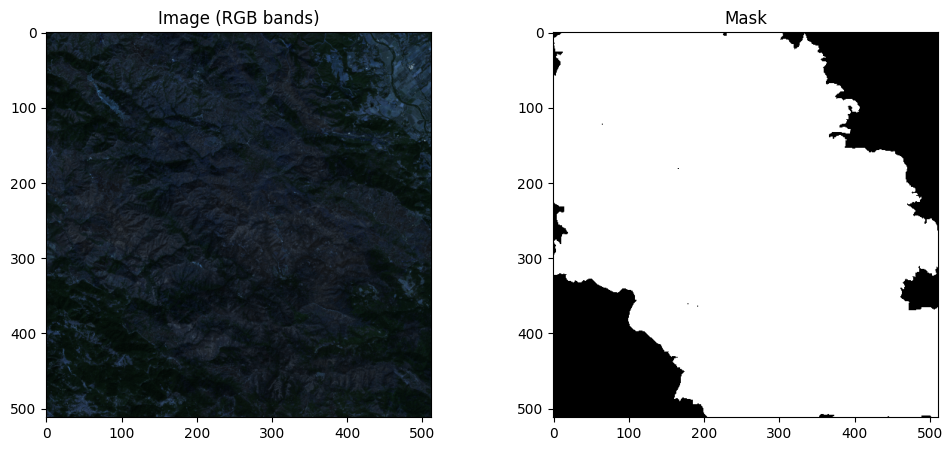

In [6]:
import os
import requests
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from osgeo import gdal
import json
import matplotlib.pyplot as plt


class CroissantSegmentationDatasetGDAL(Dataset):
    def __init__(self, croissant_path, transform=None, cache_dir="./cache"):
        with open(croissant_path) as f:
            croissant = json.load(f)

        self.transform = transform
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

        # Extract image and mask URLs from recordSet data
        self.pairs = []
        record_sets = croissant.get("recordSet", [])
        for record_set in record_sets:
            if "data" in record_set:
                for record in record_set["data"]:
                    # Look for image and mask fields in the record
                    image_url = None
                    mask_url = None

                    for key, value in record.items():
                        if "image" in key.lower():
                            image_url = value
                        elif "mask" in key.lower() or "annotation" in key.lower():
                            mask_url = value

                    if image_url and mask_url:
                        self.pairs.append((image_url, mask_url))

    def _download(self, url):
        filename = os.path.join(self.cache_dir, os.path.basename(url))
        if not os.path.exists(filename):
            r = requests.get(url)
            r.raise_for_status()
            with open(filename, "wb") as f:
                f.write(r.content)
        return filename

    def _load_image(self, path):
        ds = gdal.Open(path)
        if ds is None:
            raise RuntimeError(f"GDAL could not open {path}")
        bands = []
        for i in range(1, ds.RasterCount + 1):
            band = ds.GetRasterBand(i).ReadAsArray()
            bands.append(band)
        img = np.stack(bands, axis=-1)  # (H, W, bands)
        return img

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_url, mask_url = self.pairs[idx]
        img_path = self._download(img_url)
        mask_path = self._download(mask_url)
        img = self._load_image(img_path)
        mask = self._load_image(mask_path)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C, H, W)
        mask = torch.from_numpy(mask).long()
        if mask.ndim == 3:
            mask = mask.squeeze()
        return img, mask


# Usage example:
dataset = CroissantSegmentationDatasetGDAL("ogc_croissant.json", transform=None)
print(f"Found {len(dataset.pairs)} image-mask pairs")

if len(dataset.pairs) > 0:
    img, mask = dataset[0]
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)
else:
    print("No image-mask pairs found. Let's inspect the GeoCroissant structure:")
    with open("ogc_croissant.json") as f:
        croissant = json.load(f)

    print("RecordSet structure:")
    for i, record_set in enumerate(croissant.get("recordSet", [])):
        print(f"  RecordSet {i}: {record_set.get('name', 'unnamed')}")
        if "data" in record_set:
            print(f"    Data entries: {len(record_set['data'])}")
            if len(record_set["data"]) > 0:
                print(f"    First record keys: {list(record_set['data'][0].keys())}")
        else:
            print("    No data found")

# Plotting (only if we have data)
if len(dataset.pairs) > 0:
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if img_np.shape[2] >= 3:
        plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))
        plt.title("Image (RGB bands)")
    else:
        plt.imshow(img_np[:, :, 0], cmap="grey")
        plt.title("Image (Band 1)")
    plt.axis("on")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="grey", vmin=0, vmax=1)
    plt.title("Mask")
    plt.axis("on")
    plt.show()
else:
    print("Skipping visualization - no data available")